## 2D Geometric Transformation

Apply Basic Affine transformation 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_grid(x, y, homogenous=False):
    coords = np.indices((x, y)).reshape(2, -1)
    return np.vstack((coords, np.ones(coords.shape[1]))).astype(np.int32) if homogenous else coords

def grid_plotter(points, labels):
    markers = ['o', 'x', 's', '^', 'p', 'v']
    fig, ax = plt.subplots(figsize=(8,6))
    for i, p in enumerate(points):
        x, y = p[0], p[1]
        ax.scatter(x, y, label=labels[i], marker=markers[i], alpha=0.8, s=100)
    ax.legend(loc='lower right')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

    ax.grid(True)
    plt.show()
    
def show_image(image):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(image)
    plt.show()

In [3]:
# Define Transformations
def get_rotation(angle):
    angle = np.radians(angle)
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0, 0, 1]
    ])
def get_translation(tx, ty):
    return np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ])

def get_scale(s):
    return np.array([
        [s, 0, 0],
        [0, s, 0],
        [0, 0, 1]
    ])

R1 = get_rotation(135)
T1 = get_translation(-2, 2)
S1 = get_scale(2)

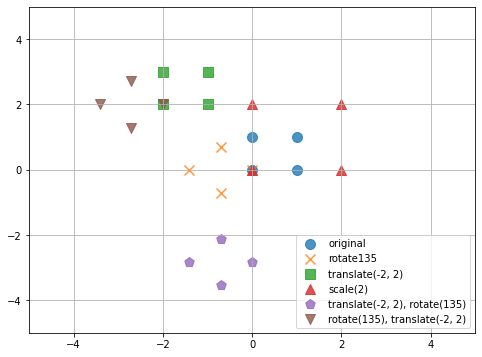

In [4]:
# Get sample coordinates
coords = get_grid(2, 2, homogenous=True)

# Apply transformation
coords_rot = R1 @ coords
coords_trans = T1 @ coords
coords_scale = S1 @ coords
coords_composite1 = R1 @ T1 @ coords
coords_composite2 = T1 @ R1 @ coords

grid_plotter([coords, coords_rot, coords_trans, coords_scale, coords_composite1, coords_composite2],
             labels=['original', 'rotate135', 'translate(-2, 2)', 'scale(2)', 'translate(-2, 2), rotate(135)', 'rotate(135), translate(-2, 2)'])


### Image Warping

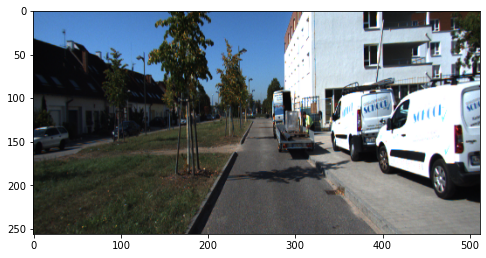

In [5]:
image_path = 'left.png'
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (512, 256))
    
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(image)
plt.show()

#### Parameters

In [6]:
height, width = image.shape[:2]
tx, ty = np.array((width // 2, height // 2))
angle = np.radians(45)
scale = 2.0

In [7]:
R = np.array([
    [np.cos(angle), np.sin(angle), 0],
    [-np.sin(angle), np.cos(angle), 0],
    [0, 0, 1]
])

T = np.array([
    [1, 0, tx],
    [0, 1, ty],
    [0, 0, 1]
])

S = np.array([
    [scale, 0, 0],
    [0, scale, 0],
    [0, 0, 1]
])

A = T@R@S@np.linalg.inv(T)
Ainv = np.linalg.inv(A)

In [8]:
# Grid to represent image coordinate I(x, y)
coords = get_grid(width, height, True)
x1, y1 = coords[0], coords[1]

# Apply transformation and nearest neighbor interpolation
warp_coords = np.round(A@coords).astype(np.int32)
x2, y2 = warp_coords[0, :], warp_coords[1, :]

# Get pixels within image
indices = np.where((x2 >= 0) & (x2 < width) &
                   (y2 >= 0) & (y2 < height))

xpix2, ypix2 = x2[indices], y2[indices]
xpix1, ypix1 = x1[indices], y1[indices]

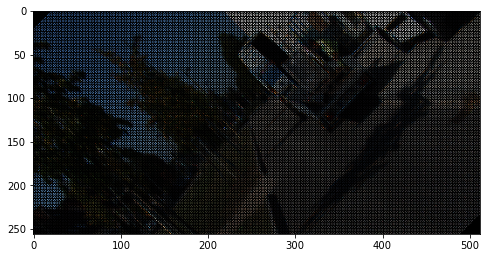

In [9]:
# Copy values to new image I'(x, y)
canvas = np.zeros_like(image)
canvas[ypix2, xpix2] = image[ypix1, xpix1]
show_image(canvas)

#### Inverse Warp

In [10]:
# set up pixel coordinate I'(x, y)
coords = get_grid(width, height, True)
x2, y2 = coords[0], coords[1]

# Apply inverse transform and round it (nearest neighbour interpolation)
warp_coords = (Ainv@coords).astype(np.int32)
x1, y1 = warp_coords[0, :], warp_coords[1, :]

# Get pixels within image boundaries
indices = np.where((x1 >= 0) & (x1 < width) &
                   (y1 >= 0) & (y1 < height))

xpix1, ypix1 = x2[indices], y2[indices]
xpix2, ypix2 = x1[indices], y1[indices]


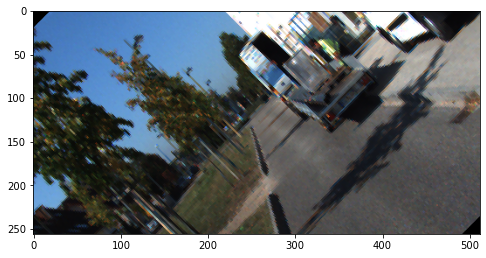

In [11]:
# Map Correspondence
canvas = np.zeros_like(image)
canvas[ypix1, xpix1] = image[ypix2,xpix2]
show_image(canvas)

## Affine Transformation (OpenCV)


In [12]:
def get_affine_cv(t, r, s):
    sin_theta = np.sin(r)
    cos_theta = np.cos(r)
    
    a_11 = s * cos_theta
    a_21 = -s * sin_theta
    
    a_12 = s * sin_theta
    a_22 = s * cos_theta
        
    a_13 = t[0] * (1 - s * cos_theta) - s * sin_theta * t[1]
    a_23 = t[1] * (1 - s * cos_theta) + s * sin_theta * t[0]

    return np.array([[a_11, a_12, a_13],
                     [a_21, a_22, a_23]])

A2 = get_affine_cv((tx, ty), angle, scale)

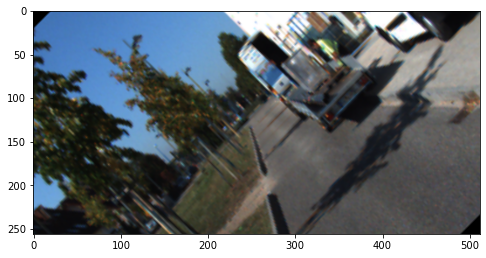

In [13]:
warped = cv2.warpAffine(image, A2, (width, height))
show_image(warped)

#### Using cv2.getRotationMatrix2D

In [14]:
A3 = cv2.getRotationMatrix2D((int(tx), int(ty)), np.rad2deg(angle), scale)

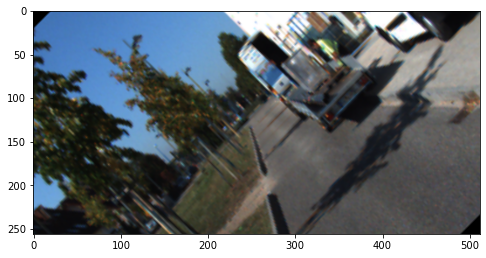

In [15]:
warped = cv2.warpAffine(image, A3, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
show_image(warped)